Load the required Libraries

In [14]:
import ipaddress         
import numpy as np
import seaborn as sns                                                                    
import pandas as pd                                                            
import matplotlib.pyplot as plt                                                 
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split                               
from sklearn.model_selection import GridSearchCV                                                                           
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve, roc_auc_score  

In [15]:
df=pd.read_csv("unbalaced_20_80_dataset.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616509 entries, 0 to 7616508
Data columns (total 85 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Flow ID            object 
 2   Src IP             object 
 3   Src Port           int64  
 4   Dst IP             object 
 5   Dst Port           int64  
 6   Protocol           int64  
 7   Timestamp          object 
 8   Flow Duration      int64  
 9   Tot Fwd Pkts       int64  
 10  Tot Bwd Pkts       int64  
 11  TotLen Fwd Pkts    float64
 12  TotLen Bwd Pkts    float64
 13  Fwd Pkt Len Max    float64
 14  Fwd Pkt Len Min    float64
 15  Fwd Pkt Len Mean   float64
 16  Fwd Pkt Len Std    float64
 17  Bwd Pkt Len Max    float64
 18  Bwd Pkt Len Min    float64
 19  Bwd Pkt Len Mean   float64
 20  Bwd Pkt Len Std    float64
 21  Flow Byts/s        float64
 22  Flow Pkts/s        float64
 23  Flow IAT Mean      float64
 24  Flow IAT Std       float64
 25  Flow IAT Max      

In [16]:
df = df.drop(['Unnamed: 0', 'Flow ID','Timestamp'], axis=1)


In [17]:
df['Src IP'] = df['Src IP'].apply(lambda x: int(ipaddress.IPv4Address(x)))
df['Dst IP'] = df['Dst IP'].apply(lambda x: int(ipaddress.IPv4Address(x)))

In [5]:
df.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,316391700,37882,2887730457,80,6,8660,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,2887730460,80,316344577,63287,6,5829,4,3,935.0,298.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,873367687,63095,2887730460,80,6,3396,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,316197053,52341,2887730460,80,6,2390,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,2887730460,80,316290942,57459,6,17362,4,3,935.0,314.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [18]:
df = pd.get_dummies(df,columns=['Label'], drop_first=True,dtype=int)

In [7]:
df.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label_ddos
0,316391700,37882,2887730457,80,6,8660,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2887730460,80,316344577,63287,6,5829,4,3,935.0,298.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,873367687,63095,2887730460,80,6,3396,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,316197053,52341,2887730460,80,6,2390,1,1,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2887730460,80,316290942,57459,6,17362,4,3,935.0,314.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [20]:
# Handle missing or infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

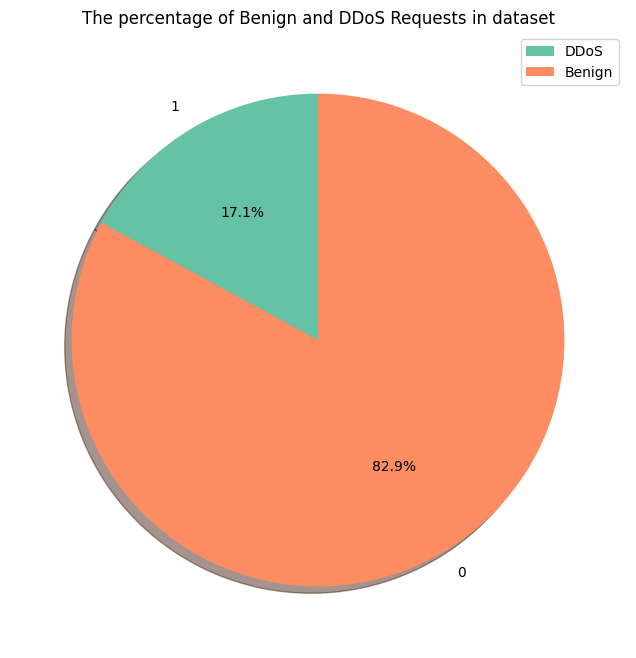

In [21]:
Label = ['1','0']
sizes = [df['Label_ddos'].value_counts()[1], df['Label_ddos'].value_counts()[0]]
plt.figure(figsize = (13,8))
colors = sns.color_palette("Set2")
plt.pie(sizes, labels=Label, autopct='%1.1f%%',shadow=True, startangle=90,colors=colors)
plt.legend(['DDoS', 'Benign'])
plt.title('The percentage of Benign and DDoS Requests in dataset')
plt.show()

MODEL, RANDOM-FORESTS CLASSSIFIER

In [39]:
# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Label_ddos'])
y = df['Label_ddos']

In [40]:
# Split the data into a 2:1 train-test ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [41]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [10, 20, 30],
    'n_estimators': [100, 200, 300],
    'n_jobs': [-1]  # Use all available CPU cores
}

In [42]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

In [43]:
# Create a Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1)

In [44]:
# Perform Grid Search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-1]})

In [45]:
# Get the best hyperparameters
best_params = grid_search.best_params_

In [47]:
print(best_params)

{'max_depth': 20, 'n_estimators': 200, 'n_jobs': -1}


In [48]:
# Train the model with the best hyperparameters
best_rf_classifier = RandomForestClassifier(random_state=42, **best_params)
best_rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)

Bad pipe message: %s [b'\x8c\x19\x11\xb0d\xfer\xdd\xf4\x1b\xaa\x9e\xd4\xb2\xa1\x1f\x9f\x99 \x08\x12s\xb7`\xae\x1b\xe4\xaek!RJ~\x9f\x08\x9d\xd6\xe5L8\xbd\x06\xfc\x8d<\xaf".S\xda\xa8\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xb4\x93\xa8\x9f\x85t\x17z3b\xea\x89$\xd9\xa9$\xaf\xc1\xfe\xc3V\xb6']
Bad pipe message: %s [b'\xc5\xd3\xe9)6dK\xae\x1d~\xb6A=\x9a\xb4\xef\xfb\xc1\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc']
Bad pipe message: %s [b"\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0

In [50]:
#Calculate accuracy for validation data
accuracy_score(y_test, best_rf_classifier.predict(X_test))

0.9999983985195915

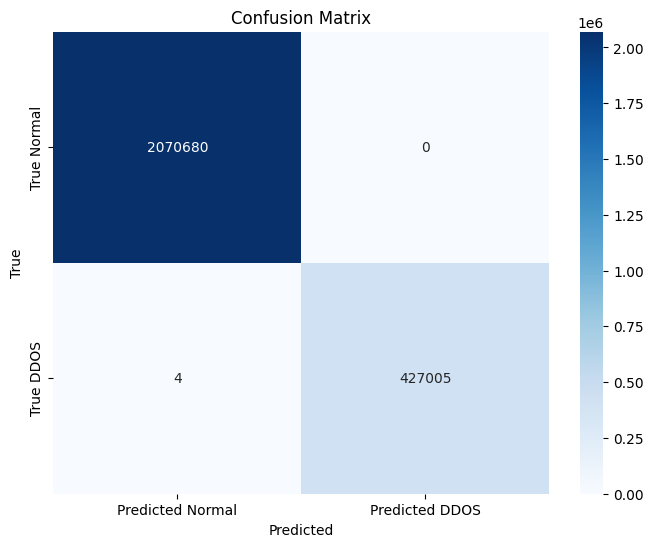

In [55]:
# Predict the labels on the test set
y_pred = best_rf_classifier.predict(X_test)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted DDOS'],
            yticklabels=['True Normal', 'True DDOS'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

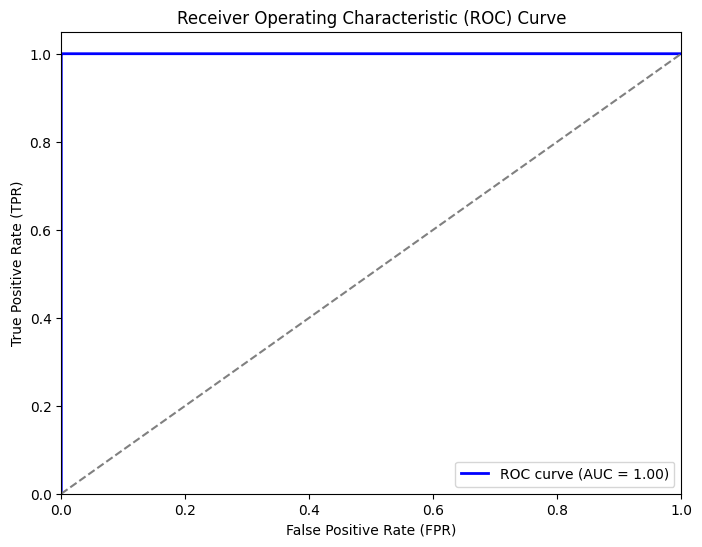

In [57]:
# Get predicted probabilities for the positive class
y_prob = best_rf_classifier.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



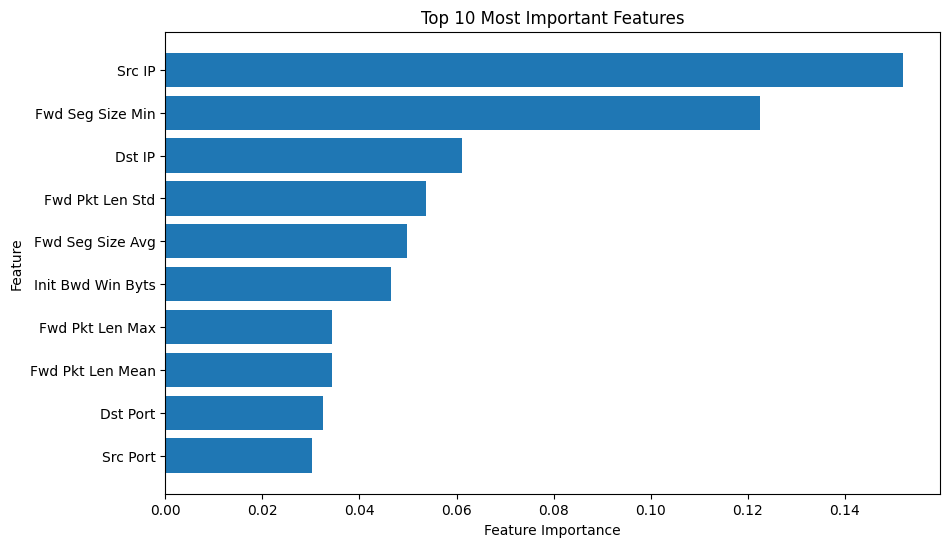

In [60]:
# Get feature importances from the Random Forest model
feature_importances = best_rf_classifier.feature_importances_

# Get the corresponding feature names
feature_names = X.columns

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top N most important features (e.g., top 10)
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importance_df['Importance'][:top_n], align='center')
plt.yticks(range(top_n), feature_importance_df['Feature'][:top_n])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top {} Most Important Features'.format(top_n))
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()
